In [1]:
import pandas as pd

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

tracks = pd.read_csv('tracks.csv', index_col=0)
features = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
tracks.head()

,track_id,track_name,first_genre,position,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,02VBYrHfVwfEWXk5DXyf0T,Leave The Door Open,1,42,0.631718,-0.358996,-0.007258,0.119020,-0.513179,-0.580800,0.140389,-0.643063,0.853481,1.095930
1,04aAxqtGp5pv12UXAg4pkq,Centuries,4,27,0.503004,-0.850943,-1.030601,1.021935,-0.513179,-0.510113,0.780807,-0.015304,1.798697,0.451594
2,08B8Ki7qlUoT58Zd1trxkl,"Requiem In D Minor, K. 626: Sequence: VI. Lacr...",5,13,-0.526709,1.777988,-2.725744,-1.824486,1.346714,3.031821,-1.920863,-0.497361,1.949065,-1.521533
3,08mG3Y1vljYA6bvDt4Wqkj,Back In Black,4,24,0.760433,-0.830511,-1.470691,0.432428,-0.485309,-0.656047,0.427672,-0.416760,2.216088,1.274237
4,09CnYHiZ5jGT1wr1TXJ9Zt,Thank You (Not So Bad),3,8,0.503004,-0.797698,0.454041,1.365191,-0.275494,1.739699,0.494152,-0.388859,0.918774,0.463751


In [2]:
seed_tracks = tracks[tracks['position'] < 2].sort_values(by=['first_genre']).reset_index(drop=True)
seeds_grouped = seed_tracks.groupby('first_genre')[features].mean().reset_index()

initial_centroids = seeds_grouped[features].values

seeded_kmeans = KMeans(
    n_clusters=5, 
    init=initial_centroids, 
    n_init=1,             # Must be 1 when passing custom init
    random_state=42
)

tracks['seeded_cluster'] = seeded_kmeans.fit_predict(tracks[features])

## K-means

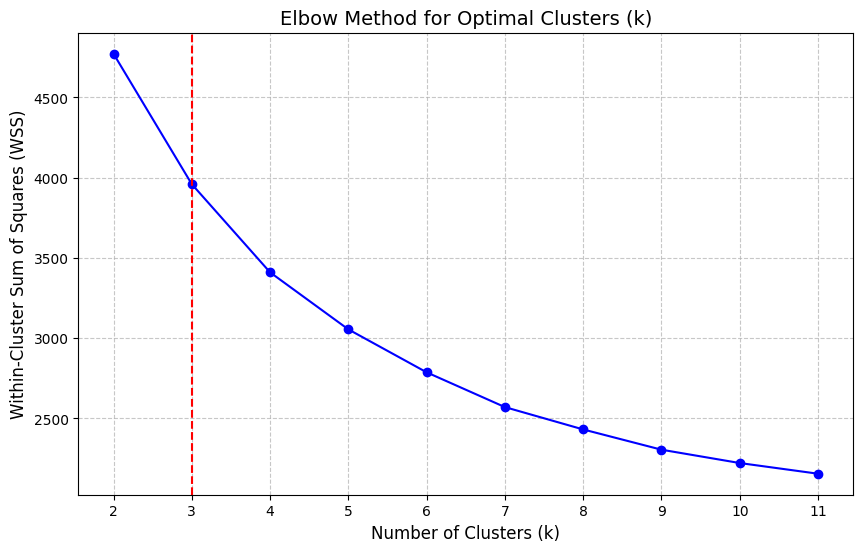

In [3]:
input = tracks[features]

# Apply PCA before clustering
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# pca_results = pca.fit_transform(tracks[features])
# tracks['PCA1'] = pca_results[:, 0]
# tracks['PCA2'] = pca_results[:, 1]
# tracks['PCA3'] = pca_results[:, 2]

# input = tracks[['PCA1','PCA2','PCA3']]

wss = []
k_range = range(2, 12)

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init=10)
    kmeans.fit(input)
    wss.append(kmeans.inertia_)

# Assign clusters using k = 3

optimal_k = 3
kmeans = KMeans(n_clusters = optimal_k, random_state = 42, n_init=10)
cluster_labels = kmeans.fit_predict(input)
tracks['k_means_cluster'] = cluster_labels

k_means_cluster_counts = tracks.groupby('k_means_cluster')['track_id'].count().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(k_range, wss, marker='o', color='b', linestyle='-')
plt.title('Elbow Method for Optimal Clusters (k)', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=12)
plt.axvline(x=optimal_k, color='r', linestyle='--')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)

In [4]:
k_means_cluster_counts

,k_means_cluster,track_id
0,0,61
1,1,479
2,2,142


In [5]:
# Cluster Profile

# Apply both mean and std to every feature in the list
cluster_profile = tracks.groupby('k_means_cluster')[features].agg(['mean', 'std']).reset_index()
cluster_profile

k_means_cluster popularity           acousticness           danceability  \
                        mean       std         mean       std         mean   
0               0  -3.003929  0.813519    -0.490653  0.680413     0.756707   
1               1   0.213868  0.629590    -0.325343  0.665154     0.272324   
2               2  -1.034314  0.717146     1.742705  0.217018    -1.394263   

               energy           instrumentalness  ...  liveness            \
        std      mean       std             mean  ...      mean       std   
0  0.437410  0.352547  0.607660         1.597618  ... -0.146412  0.997959   
1  0.762261  0.363898  0.667913        -0.453668  ...  0.084423  1.004295   
2  0.647818 -1.755570  0.423369         1.650206  ... -0.390669  0.524759   

   loudness           speechiness               tempo             valence  \
       mean       std        mean       std      mean       std      mean   
0 -0.151816  0.438038   -0.003311  0.708853  0.141848  0.164833 -0.669819   
1  0.386044  0.309558    0.148310  1.204986  0.046262  0.884348  0.233392   
2 -1.865954  1.004633   -0.430863  0.330574 -0.494278  1.194634 -0.943172   

             
        std  
0  0.850652  
1  0.894565  
2  0.668949  

[3 rows x 21 columns]

In [ ]:
import seaborn as sns

## t-SNE plots to evaluate K-means

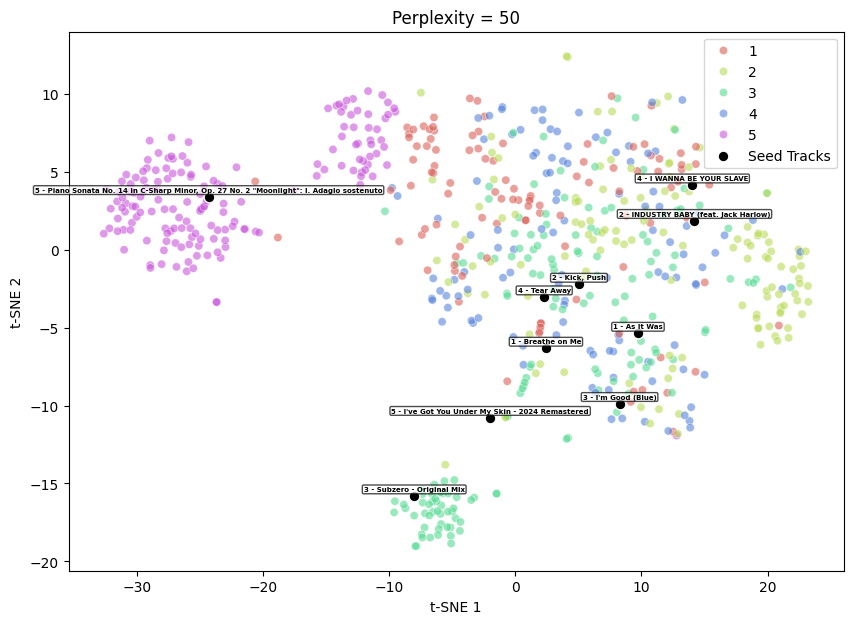

In [7]:
from sklearn.manifold import TSNE

comparison = range(20, 200, 20)
comparison = [50]

for p in comparison:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca', learning_rate='auto')
    tsne_results = tsne.fit_transform(tracks[features])

    # 4. Add results back to a temporary dataframe for plotting
    tracks['tsne-2d-one'] = tsne_results[:,0]
    tracks['tsne-2d-two'] = tsne_results[:,1]

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="first_genre",
        palette=sns.color_palette("hls", tracks['first_genre'].nunique()),
        data=tracks,
        legend="full",
        alpha=0.6
    )

    seeds_to_label = tracks[tracks['track_id'].isin(seed_tracks['track_id'])]

    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        data=seeds_to_label,
        color='black',
        s=60,         # Slightly larger than default points
        marker='o',   # Circular dot
        edgecolor='white', # White border makes them pop against dark colors
        linewidth=1,
        label='Seed Tracks',
        zorder=5      # Ensures dots are drawn on top of the other points
    )

    for i in range(len(seeds_to_label)):
        plt.text(
            x=seeds_to_label.iloc[i]['tsne-2d-one'],
            y=seeds_to_label.iloc[i]['tsne-2d-two'] + 0.3, # Offset text slightly above dot
            s=f'{seeds_to_label.iloc[i]['first_genre']} - {seeds_to_label.iloc[i]['track_name']}', 
            fontsize=5,
            weight='bold',
            ha='center', # Center the text over the dot
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.2'),
            zorder=10    # Labels stay on top of dots
        )

    plt.title(f'Perplexity = {p}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

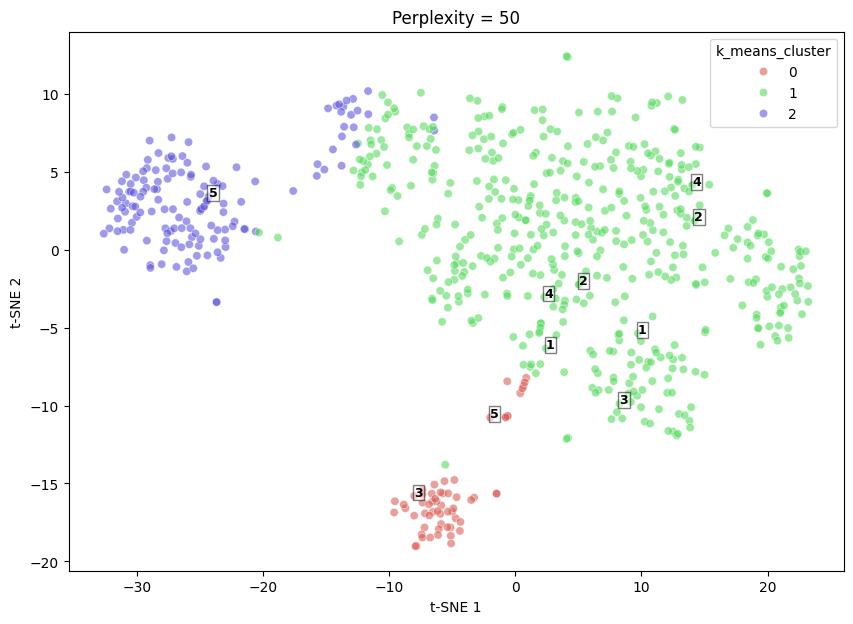

In [8]:
from sklearn.manifold import TSNE

comparison = range(20, 200, 20)
comparison = [50]

for p in comparison:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca', learning_rate='auto')
    tsne_results = tsne.fit_transform(tracks[features])

    # 4. Add results back to a temporary dataframe for plotting
    tracks['tsne-2d-one'] = tsne_results[:,0]
    tracks['tsne-2d-two'] = tsne_results[:,1]

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="k_means_cluster",
        palette=sns.color_palette("hls", tracks['k_means_cluster'].nunique()),
        data=tracks,
        legend="full",
        alpha=0.6
    )

    seeds_to_label = tracks[tracks['track_id'].isin(seed_tracks['track_id'])]
    for i in range(len(seeds_to_label)):
        plt.text(
            x=seeds_to_label.iloc[i]['tsne-2d-one'],
            y=seeds_to_label.iloc[i]['tsne-2d-two'], 
            s=seeds_to_label.iloc[i]['first_genre'], 
            fontsize=9,
            weight='bold',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', pad=1) # Makes text readable
        )

    plt.title(f'Perplexity = {p}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

## K-means with seeded clusters

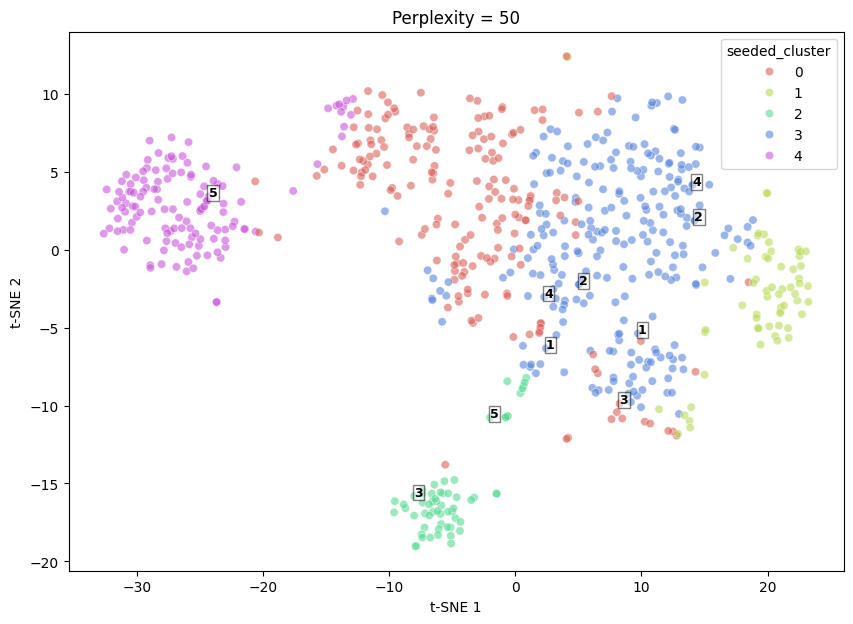

In [17]:
from sklearn.manifold import TSNE

comparison = range(20, 200, 20)
comparison = [50]

for p in comparison:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca', learning_rate='auto')
    tsne_results = tsne.fit_transform(tracks[features])

    # 4. Add results back to a temporary dataframe for plotting
    tracks['tsne-2d-one'] = tsne_results[:,0]
    tracks['tsne-2d-two'] = tsne_results[:,1]

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="seeded_cluster",
        palette=sns.color_palette("hls", tracks['seeded_cluster'].nunique()),
        data=tracks,
        legend="full",
        alpha=0.6
    )

    seeds_to_label = tracks[tracks['track_id'].isin(seed_tracks['track_id'])]
    for i in range(len(seeds_to_label)):
        plt.text(
            x=seeds_to_label.iloc[i]['tsne-2d-one'],
            y=seeds_to_label.iloc[i]['tsne-2d-two'], 
            s=seeds_to_label.iloc[i]['first_genre'], 
            fontsize=9,
            weight='bold',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', pad=1) # Makes text readable
        )

    plt.title(f'Perplexity = {p}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

In [16]:
output = tracks[['track_id', 'track_name', 'first_genre', 'position', 'seeded_cluster', 'k_means_cluster'] + features]
output.to_csv('clustered_tracks.csv')